In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

In [3]:
df = pd.read_csv('../data/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Add the summary text to actual text

In [4]:
df['Text'] = df['Text'] + ' ' + df['Summary']

In [5]:
# Delete unused columns
del df['Id']
del df['ProfileName']
del df['Summary']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']
del df['Time']
del df['ProductId']

In [6]:
df.head()

,UserId,Score,Text
0,A3SGXH7AUHU8GW,5,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,1,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,4,This is a confection that has been around a fe...
3,A395BORC6FGVXV,2,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,5,Great taffy at a great price. There was a wid...


In [7]:
df.loc[df['Score'] <= 3, 'ReviewSentiment'] = 0
df.loc[df['Score'] > 3, 'ReviewSentiment'] = 1

df['ReviewSentiment'] = df['ReviewSentiment'].astype(int)

In [8]:
df.isna().sum()

UserId              0
Score               0
Text               27
ReviewSentiment     0
dtype: int64

In [9]:
#convert na to ""
df['Text'].fillna("", inplace=True)

In [10]:
def preprocess(s):
    # Remove html tags
    s = re.sub('<\S+>', '', s)
    # Replace urls with token
    s = re.sub(r'http:\S+', 'url', s)
    s = re.sub(r'https:\S+', 'url', s)
    
    s = s.lower()
    # Remove any other special characters
    s = re.sub(r'[^a-z ]', ' ', s)
    
    words = s.split()
    result = []
    
    # Remove stop words and lemmatize the words
    for word in words:
        if word in stop_words:
            continue
        word = lemmatizer.lemmatize(word)
        result.append(word)
    return ' '.join(result)
    

In [11]:
preprocess(df['Text'][0])

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better good quality dog food'

In [12]:
df['Text'] = df['Text'].apply(preprocess)

In [15]:
negative = df[df['ReviewSentiment']==0]
positive = df[df['ReviewSentiment']==1]
print('Number of negative samples:', len(negative))
print('Number of positive samples:', len(positive))

Number of negative samples: 124677
Number of positive samples: 443777


Number of positive samples is very high. Let us downsize it

In [16]:
positive_downsampled = resample(positive, replace=True, # sample with replacement
                                n_samples=len(negative), # match number in minority class
                                random_state=1)
print('Number of positive downsampled:', len(positive_downsampled))

downsampled = pd.concat([negative, positive_downsampled])
print('Total Number of rows after downsampling:', len(downsampled))

Number of positive downsampled: 124677
Total Number of rows after downsampling: 249354


In [17]:
x_train, x_test, y_train, y_test = train_test_split(downsampled['Text'], downsampled['ReviewSentiment'], test_size=0.2, random_state=1, stratify=downsampled['ReviewSentiment'])

In [18]:
print('Number of train samples:', len(x_train))
print('Number of test samples:', len(x_test))

Number of train samples: 199483
Number of test samples: 49871


In [19]:
# Delete unused objects
del stop_words
del lemmatizer
del df
del downsampled
del negative
del positive

## Logistic Regression using CountVectorizer

In [20]:
cv = CountVectorizer()
fv_train = cv.fit_transform(x_train)
fv_test = cv.transform(x_test)

In [21]:
print('Shape of train count vector:', fv_train.shape)
print('Shape of test count vector:', fv_test.shape)

Shape of train count vector: (199483, 64878)
Shape of test count vector: (49871, 64878)


In [ ]:
lr = LogisticRegression(penalty='l2', random_state=1, max_iter=1000)
parameters = {'solver':('sag', 'saga'), 'C':[0.5, 1, 2, 5, 10]}
grid_cv = GridSearchCV(lr, parameters, cv=3)
grid_cv.fit(fv_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

In [31]:
# Check score for training data
grid_cv.score(fv_train, y_train)
# Check score for test data
grid_cv.score(fv_test, y_test)

0.8878707064225703

In [32]:
# Write model to disk
pickle.dump(grid_cv, open('model/lr_grid_model_plot', 'wb'))

In [33]:
loaded_grid_cv = pickle.load(open('model/lr_grid_model_plot', 'rb'))
loaded_grid_cv.score(fv_test, y_test)

0.8878707064225703

In [34]:
loaded_grid_cv.cv_results_

{'mean_fit_time': array([168.3912375 , 177.3943127 , 169.87524947, 174.46148419,
        166.86490703, 171.36345903, 165.94198887, 173.14188313,
        169.36916526, 177.19089961]),
 'std_fit_time': array([0.93105167, 2.46501641, 0.68788752, 1.6560086 , 1.12497918,
        1.53293905, 1.23950572, 2.15538095, 1.07221694, 1.4544256 ]),
 'mean_score_time': array([0.01783649, 0.01806688, 0.02003543, 0.01823266, 0.02531401,
        0.01833224, 0.01771784, 0.01777291, 0.01764854, 0.01790229]),
 'std_score_time': array([8.09400289e-04, 5.82764753e-04, 1.20082749e-03, 5.30157735e-04,
        1.08369720e-02, 6.09824703e-04, 1.86194175e-04, 1.90966882e-04,
        5.79150525e-05, 7.69868675e-04]),
 'param_C': masked_array(data=[0.5, 0.5, 1, 1, 2, 2, 5, 5, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['sag', 'saga', 'sag', 'saga', 'sag'

[0.8826265997804154, 0.8805011045228692, 0.88252634101253, 0.8805963513625713, 0.8827218467708952, 0.8806063773298266, 0.8826917691706851, 0.8806164026939708, 0.8826115621865324, 0.8805913376250549]


Text(0.5, 1.0, 'C vs Mean Accuracy')

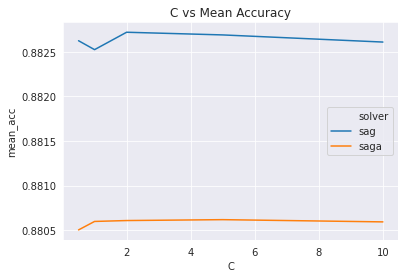

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

C = []
solver = []
mean_acc = []
for i, param in enumerate(loaded_grid_cv.cv_results_['params']):
    C.append(param['C'])
    solver.append(param['solver'])
    mean_acc.append(loaded_grid_cv.cv_results_['mean_test_score'][i])
print(mean_acc)
data = pd.DataFrame({'C':C, 'mean_acc':mean_acc, 'solver': solver})

sns.lineplot(x='C',y='mean_acc', hue='solver', data=data, ci= None).set_title('C vs Mean Accuracy')